In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src import utils
import seaborn as sns
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import norm, multivariate_normal


In [2]:
sns.set_theme()
beta_true = .15
alpha = 0.1
gamma = 0.05
N = 100
T = 52
seed = 29

In [3]:
# def compute_hazard(beta, I, N, F, fC, rC, het):
#     hazard = I.sum() * beta[0] * np.ones(N)
#     if het:
#         hazard += (fC * I).sum(1) * beta[F+1]
#         hazard += (rC * I).sum(1) * beta[-1]
#     return hazard

In [4]:
F = np.arange(N) % 5
R = np.arange(N) % (N // 2)
fC = utils.contact_matrix(F)
rC = utils.contact_matrix(R)

In [5]:
# def simulator(alpha, beta, gamma, N, T, seed, het=False):
#     if not het:
#         beta = [beta]
#     X  = np.empty((N, T))
#     np.random.seed(seed)
#     X[:, 0] = np.random.binomial(1, alpha, N)
#     F = np.arange(N) % 5
#     R = np.arange(N) % (N // 2)
#     fC = contact_matrix(F)
#     rC = contact_matrix(R)
#     for t in range(1, T):
#         I = X[:, t-1]
#         # components dependent on individual covariates
#         hazard = compute_hazard(beta, I, N, F, fC, rC, het)
#         p = 1 - np.exp(-hazard / N)
#         new_infections = np.random.binomial(1, p, N)
#         X[:, t] = np.where(I, np.ones(N), new_infections)
#         discharge = np.random.binomial(1, gamma, N)
#         screening = np.random.binomial(1, alpha, N)
#         X[:, t] = np.where(discharge, screening, X[:, t])
#     return X

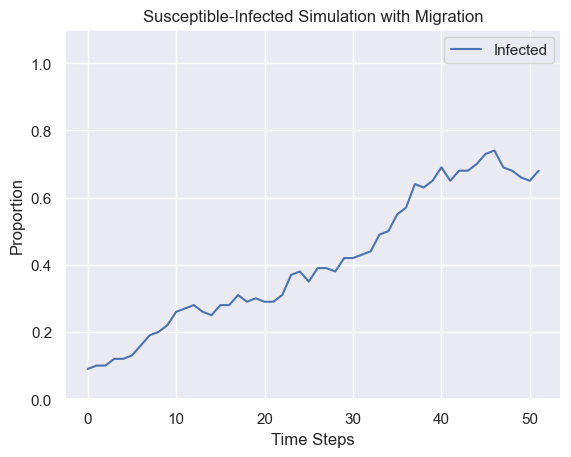

In [6]:
X_o = utils.simulator(alpha, beta_true, gamma, N, T, seed)
I_o = X_o.sum(0).astype(int)
plt.plot(I_o / N, label="Infected")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

In [7]:
# def x_loglikelihood(beta, alpha, gamma, N, T, X, het=False):
#     ans = np.log(
#         alpha ** X_o[:, 0] * (1 - alpha) ** (1 - X_o[:, 0])
#         ).sum()
#     if not het:
#         beta = [beta]
#     F = np.arange(N) % 5
#     R = np.arange(N) % (N // 2)
#     fC = contact_matrix(F)
#     rC = contact_matrix(R)
#     for t in range(1, T):
#         xs = X[:, t-1]
#         xt = X[:, t]
#         hazard = compute_hazard(beta, xs, N, F, fC, rC, het)
#         ans += (xt * xs  * np.log(
#             gamma * alpha + (1 - gamma)
#         )).sum()
#         ans += (xt * (1 - xs)  * np.log(
#             gamma * alpha + (1 - gamma) * (1 - np.exp(- hazard / N))
#         )).sum()
#         ans += ((1 - xt) * xs  * np.log(
#             gamma * (1 - alpha) + 1e-8
#         )).sum()
#         ans += ((1 - xt) * (1 - xs) * np.log(
#             gamma *(1 - alpha) + (1 - gamma) * (np.exp(- hazard/ N))
#         )).sum()
#     return ans         
    

In [8]:
# def i_loglikelihood(beta, alpha, gamma, N, T, I):
#     ans = np.log(alpha ** I[0] * (1 - alpha) ** (N - I[0]))
#     for t in range(1, T):
#         Is = I[t-1]
#         It = I[t]
#         # ans += (It - Is) * np.log((1 - np.exp(- beta * Is / N)))
#         # ans += (N - It) * np.log(np.exp(- beta * Is / N))
#         k_min = max(0, It + Is - N)
#         k_max = min(It, Is)
#         p = 0
#         for k in range(k_min, k_max + 1):
#             A = (gamma * alpha + (1 - gamma)) ** k 
#             B = (gamma * alpha + (1 - gamma) * (1 - np.exp(- beta * Is / N))) ** (It - k)
#             C = (gamma * (1 - alpha) + 1e-8) ** (Is - k)
#             D = (gamma * (1 - alpha) + (1 - gamma) * (np.exp(- beta * Is / N))) ** (N - It - Is + k)
#             z = A * B * C * D
#             p += z
#         ans += np.log(p)
#     return ans   

## Homogeneous Transmission

In [10]:
def f(beta):
    return - utils.x_loglikelihood(beta, alpha, gamma, N, T, X_o, het=False)

res = minimize_scalar(f, bounds=(0.01,1), method="bounded", options={"disp": True, "maxiter": 18})
res.x


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


0.13865727373214706

In [11]:
np.log(0.138657)

-1.9757520213574071

In [12]:
np.log(0.15)

-1.8971199848858813

In [24]:
np.exp(-1.985 + .145**2/2)
# NPE estimate matches MLE quite closely...

0.13883244564185623

In [26]:
# np.random.seed(4)
S = 500
M = - res.fun
sample = np.empty(S)
attempts = 0
np.random.seed(4)
for s in range(S):
    accept = False
    while not accept:
        logbeta = norm(-3, 1).rvs()
        attempts += 1
        u = np.random.uniform(0,1)
        if np.log(u) < x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o) - M:
            accept = True
            sample[s] = logbeta
        if attempts % 1000 == 0:
            print(attempts)
    
sample.mean(), sample.std(), np.exp(sample).mean()

1000
2000
3000
4000
5000
6000
7000
8000


(-1.9896766625425661, 0.09485686075128438, 0.1373552100554482)

(array([  7.,  17.,  47.,  81., 111., 115.,  74.,  35.,  10.,   3.]),
 array([-2.26087946, -2.20505941, -2.14923937, -2.09341932, -2.03759928,
        -1.98177923, -1.92595919, -1.87013914, -1.81431909, -1.75849905,
        -1.702679  ]),
 <BarContainer object of 10 artists>)

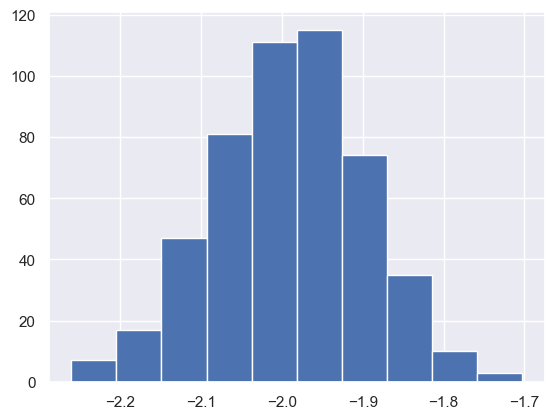

In [27]:
plt.hist(sample)

(array([ 11.,  34.,  72., 104., 123.,  85.,  42.,  20.,   6.,   3.]),
 array([0.10425875, 0.11205235, 0.11984596, 0.12763956, 0.13543316,
        0.14322676, 0.15102036, 0.15881396, 0.16660757, 0.17440117,
        0.18219477]),
 <BarContainer object of 10 artists>)

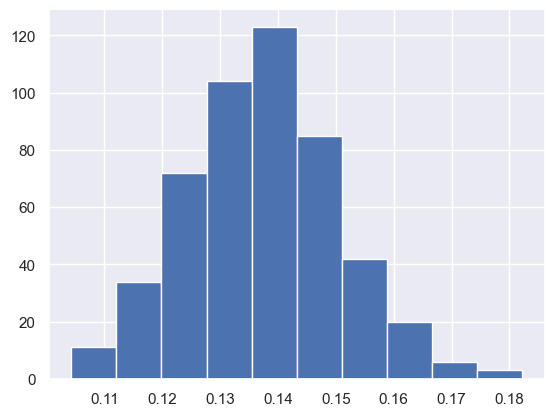

In [29]:
plt.hist(np.exp(sample))

In [11]:
# np.random.seed(4)
# S = 100
S = 500
M = - res.fun
sample = np.empty(S)
attempts = 0
np.random.seed(4)
for s in range(S):
    accept = False
    while not accept:
        logbeta = norm(-3, 1).rvs()
        attempts += 1
        u = np.random.uniform(0,1)
        if np.log(u) < x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o) - M:
            accept = True
            sample[s] = logbeta
        if attempts % 1000 == 0:
            print(attempts)
    
sample.mean(), sample.std(), np.exp(sample).mean()

1000
2000
3000
4000
5000
6000
7000
8000


(-1.9896766625425661, 0.09485686075128438, 0.1373552100554482)

In [12]:
attempts, np.log10(attempts)

(8733, 3.941163460158473)

## Identifiability

In [12]:
def nll(beta, alpha, gamma, N, T, X, het):
    # beta = beta / np.array([1, 300, 300, 300, 300, 300, 300])
    return - x_loglikelihood(beta, alpha, gamma, N, T, X, het)

In [21]:
res1 = minimize(
    nll, x0 = [0.15, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8], 
    args = (alpha, gamma, N, T, X_o, True),
    bounds = [(0.0, None) for _ in range(7)], tol=0.001
)
res1.x

array([1.48475688e-01, 9.89837923e-09, 9.89837923e-09, 1.05062020e-01,
       9.89837923e-09, 9.89837923e-09, 9.89837923e-09])

In [ ]:
def f2(beta):
    return - x_loglikelihood(beta, alpha, gamma, N, T, X_o, het=True)

res = minimize_scalar(f, bounds=(0.01,1), method="bounded", options={"disp": True, "maxiter": 18})
res.x

## Heterogeneous Transmission

In [13]:
beta_true = np.array([.05, .02, .04, .06, .08, .1, .05])
alpha = 0.1
gamma = 0.05
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
seed = 31

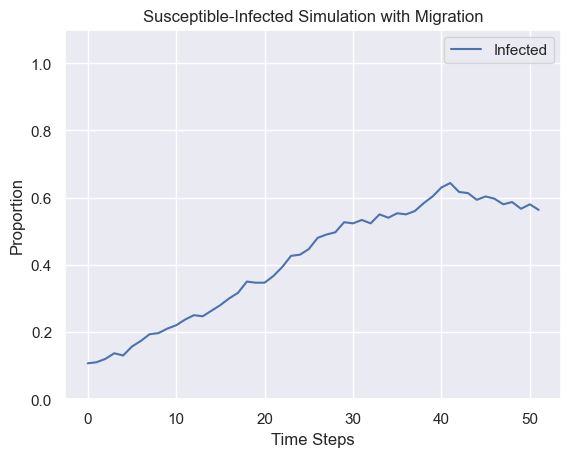

In [15]:
X_o = utils.simulator(alpha, beta_true, gamma, N, T, seed=31, het=True)
I_o = X_o.sum(0).astype(int)
plt.plot(I_o / N, label="Infected")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

In [16]:
res2 = minimize(
    utils.nll, x0 = beta_true, args = (alpha, gamma, N, T, X_o, True),
    bounds = [(0.0, None) for _ in range(7)], tol=0.001
)
res2.x

array([0.04999051, 0.0199962 , 0.06521597, 0.05998861, 0.07998481,
       0.10592577, 0.04999051])

In [2]:
np.log(np.array([0.04968622, 0.09937244, 0.31859135, 0.29811733, 0.39748977,
       0.53240004, 5.00131303]))

array([-3.00202765, -2.30888047, -1.14384603, -1.21026815, -0.92258608,
       -0.63036012,  1.60970048])

In [18]:
res2.fun

2842.7474873568417

In [29]:
x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o, het=True)

-2898.7002914894024

In [39]:
theta_s = multivariate_normal(prior_mu).rvs()

In [40]:
prior.logpdf(theta_s)

-13.350427165604046

In [41]:
def loglike(logbeta):
    return x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o, het=True)

In [95]:
# metropolis hastings
prior = multivariate_normal(prior_mu)
S = 9000
post_sample = np.empty((S, 7))
theta_s = multivariate_normal(prior_mu).rvs()
sigma = 1
accept = np.empty(S)
post_sample[0] = theta_s
accept[0] = 1
post_cur = prior.logpdf(theta_s) + loglike(theta_s)
u = np.random.uniform(size=S)
np.random.seed(4)
for s in range(1, S):
    theta_t = multivariate_normal(theta_s, sigma).rvs()
    post_prop = prior.logpdf(theta_t) + loglike(theta_t)
    log_A = post_prop - post_cur
    if np.log(u[s]) <= log_A:
        theta_s = theta_t
        post_cur = post_prop
        accept[s] = True
    else:
        accept[s] = False
    post_sample[s] = theta_s
    
    if s % 1000 == 0: print(s)

1000
2000
3000
4000
5000
6000
7000
8000


In [ ]:
# .0572, .0961, .248, .175, .260, .502, 5.21

#### rejection sampling

In [94]:
prior_mu = np.array([-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1])

S = 100
M = - res2.fun
sample = np.empty((S, 7))
attempts = 0
np.random.seed(4)
for s in range(S):
    accept = False
    while not accept:
        logbeta = multivariate_normal(prior_mu).rvs()
        attempts += 1
        u = np.random.uniform(0,1)
        if np.log(u) < x_loglikelihood(np.exp(logbeta), alpha, gamma, N, T, X_o, True) - M:
            accept = True
            sample[s] = logbeta
        if attempts % 10000 == 0:
            print(attempts)
    print(s)
    
sample.mean(0), sample.std(0), np.exp(sample).mean(0)

0
1
2
3
10000
4
20000
30000
5
6
40000
7
8
9
10
50000
11
12
13
60000
14
15
70000
16
80000
17
18
19
90000
20
21
100000
110000
22
23
24
25
120000
26
130000
27
28
29
30
140000
150000
31
32
33
34
35
160000
36
37
38
39
170000
180000
40
41
190000
42
200000
43
44
210000
45
46
47
220000
48
49
50
51
230000
240000
52
53
250000
54
260000
55
56
57
58
270000
280000
59
290000
60
300000
61
62
63
64
310000
65
66
67
68
320000
69
70
71
330000
72
73
74
340000
75
76
350000
77
78
360000
370000
79
380000
80
390000
81
400000
410000
420000
82
430000
83
440000
84
450000
85
86
87
88
89
460000
470000
480000
90
91
92
93
490000
94
95
500000
96
97
98
99


(array([-2.89239915, -2.51795655, -1.46955946, -1.87637004, -1.27098948,
        -0.71531124,  1.58937256]),
 array([0.27421243, 0.6164151 , 0.39176559, 0.55196345, 0.34768415,
        0.22982626, 0.37067454]),
 array([0.05717566, 0.09610881, 0.24757036, 0.17536349, 0.29594678,
        0.50199447, 5.21070125]))

### load posterior sample

In [7]:
ps = np.load("posterior_sample.npy")

In [8]:
np.exp(ps).mean(0)

array([0.05717566, 0.09610881, 0.24757036, 0.17536349, 0.29594678,
       0.50199447, 5.21070125])

In [9]:
np.exp(ps).std(0)

array([0.01243581, 0.05590532, 0.09396056, 0.08626314, 0.09054331,
       0.11512704, 1.68905677])